# Test Technique – Moov AI
**Candidat** : Toufik Mechouma  
**Poste** : Scientifique de données  
**Objectif** : Prévoir les ventes futures à partir de données historiques (sotres sales forecasting )  

## Question 1 – Préparation des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
class DataAssessment:

  """A class for assessing and cleaning data quality in pandas DataFrames.

  The DataAssessment class provides methods to evaluate data quality across multiple
  dimensions including accuracy, completeness, and coherence, along with reporting
  and cleaning capabilities.

  Attributes:
      df (pd.DataFrame): The pandas DataFrame to be assessed and cleaned.
  """

  def __init__(self):
    """Initializes the DataAssessment with a pandas DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to be assessed. Must be a valid pandas DataFrame.
    """
    self.df = pd.DataFrame()

  def load_data(self,path):
    """Loads data from a CSV file into a pandas DataFrame.

    Args:
        path (str): The file path of the CSV file to be loaded.
    """
    # load the dataset
    self.df = pd.read_csv(path, encoding='latin-1')


  def visualize_outliers(self,df:pd.DataFrame,col:str):
    """Visualize with boxplot the distribution of a variable with outliers."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[col])
    plt.title(f"{col}  Distribution with Outliers")
    plt.show()

  def visualize_duplicates(self, df):
    """Visualize duplicate rows in the DataFrame."""
    # Create mask for all duplicate rows (keeping all occurrences)
    dupes_mask = df.duplicated(keep=False)
    # Check if there are any duplicate rows
    duplicate_count = dupes_mask.sum()
    if duplicate_count == 0:
      print("No duplicate rows found.")
    else:
      # Create a boolean dataframe indicating duplicates
      bool_df = pd.DataFrame(False, index=df.index, columns=df.columns)
      for col in df.columns:
          bool_df[col] = dupes_mask

      # Set up the visualization
      plt.figure(figsize=(12, 6))
      # Create heatmap - only showing duplicate rows
      sns.heatmap(
          bool_df[dupes_mask],  # Only show duplicate rows
          cmap=['white', 'red'],  # Simple two-color scheme
          cbar=False,
          yticklabels=False,  # Hide row labels for cleaner display
          linewidths=0.5,
          linecolor='lightgray'
      )
      # Customize the plot
      plt.title("Duplicate Rows Visualization", pad=20, fontsize=14)
      plt.xlabel("Columns", labelpad=10)
      plt.ylabel("Duplicate Rows", labelpad=10)

      # Add count of duplicates to the plot
      plt.text(0.5, -0.1,
                f"Total duplicate rows: {duplicate_count} ({duplicate_count/len(df):.1%})",
                ha='center', transform=plt.gca().transAxes)

      plt.tight_layout()
      plt.show()

  def distribution_analysis(self,df:pd.DataFrame, col:str):
    """Visualize the distribution of numerical columns in the DataFrame."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')


  def print_outliers_report(self, outliers_dict:dict):
    print("---------Outliers Analysis Report----------")
    for cc in outliers_dict.keys():
      print(f"Column : {cc}")
      print(f"z_scores : {outliers_dict[cc]['z_scores']}")
      print(f"nbr_outliers : {outliers_dict[cc]['nbr_outliers']}")
      print(f"outliers_percent : {outliers_dict[cc]['outliers_percent']:.2f}%")
      print('----------------------------------------\n')

  def get_outliers(self, df:pd.DataFrame, threshold: float = 3.0):

    """Identifies outliers in a specified column of the DataFrame.

    Args:
        column (str): The name of the column to analyze for outliers.
        threshold (float, optional): The z-score threshold for identifying outliers.
            Defaults to 3.0.
    """
    outliers_dict = {}
    col_outliers_dict = {}
    col_outliers_dict_keys = ['z_scores', 'nbr_outliers', 'outliers_percent']
    for c in df.columns.tolist():
      # Check if the column is numeric before calculating z-scores
      if pd.api.types.is_numeric_dtype(df[c]):
        z_scores = np.abs(stats.zscore(df[c]))
        outliers = df[z_scores > 3]
        nbr_outliers = len(outliers)
        outliers_percent = (len(outliers)/df.shape[0])*100
        values = [z_scores,nbr_outliers, outliers_percent]
        col_outliers_dict = {k: v for k, v in zip(col_outliers_dict_keys, values)}
        outliers_dict[c] = col_outliers_dict
    return outliers_dict


  def check_accuracy(self,df:pd.DataFrame,dtype_mapping:dict):
    """Assesses data accuracy by checking for type errors and outliers.

    Evaluates each column for:
    - Type consistency
    - Statistical outliers
    - Invalid values based on data type

    Returns:
        Accuracy Report
    Note:
        Implementation pending - currently returns empty dict.
    """
    shape = self.df.shape # the Dataframe shape
    print("The dimension of the Dataset is :",shape)
    print(" ")
    df = df.astype(dtype_mapping) # type conversion
    print("-----The dupplicates Analysis Report-------")
    print(" ")
    duplicate_rows = df[df.duplicated(keep=False)] # Check for completely identical rows
    nbr_duplicated_rows = duplicate_rows.shape[0] # number of duplicate rows
    print("The number of duplicate rows is :",nbr_duplicated_rows)
    perc_duplicated_rows = (nbr_duplicated_rows / shape[0]) * 100 # percentage of duplicate rows
    print(f"The percentage of duplicate rows is : {perc_duplicated_rows:.2f}%")



  def get_missing_values(self,df:pd.DataFrame):
    # Check for missing values in entire DataFrame
    miss_val = df.isnull().sum()
    print('-------------------------------')
    print("Missing values count per column:")
    print(miss_val)
    print('-------------------------------')
    # Check percentage of missing values
    miss_val_perc = df.isnull().mean() * 100
    print("Missing values percentage per column:")
    for column, percentage in miss_val_perc.items():
      print(f"{column}: {percentage:.2f}%")
    print('-------------------------------')

  def visualize_missing_values(self,df:pd.DataFrame):
    # Create a heatmap of missing values (True if missing, False otherwise)
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title("Missing Values Heatmap")
    plt.show()

  def check_completeness(self):
    """Assesses data completeness by checking for missing values."""
    self.get_missing_values(self.df)


In [5]:
# Columns types defintion
dtype_mapping = {
    'Row ID': 'int32',
    'Order ID': 'string',
    'Order Date': 'datetime64[ns]',
    'Ship Date': 'datetime64[ns]',
    'Ship Mode': 'category',
    'Customer ID': 'string',
    'Customer Name': 'string',
    'Segment': 'category',
    'Country': 'category',
    'City': 'string',
    'State': 'category',
    'Postal Code': 'string',
    'Region': 'category',
    'Product ID': 'string',
    'Category': 'category',
    'Sub-Category': 'category',
    'Product Name': 'string',
    'Sales': 'float64',
    'Quantity': 'int32',
    'Discount': 'float64',
    'Profit': 'float64'
}

In [4]:
path='/content/stores_sales_forecasting.csv'

In [7]:
data_assessment = DataAssessment()
data_assessment.load_data(path)

### 📈 Duplicates statistics

In [8]:
data_assessment.check_accuracy(data_assessment.df,dtype_mapping)

The dimension of the Dataset is : (2121, 21)
 
-----The dupplicates Analysis Report-------
 
The number of duplicate rows is : 0
The percentage of duplicate rows is : 0.00%


### 🔍 Duplicates visualization

In [9]:
data_assessment.visualize_duplicates(data_assessment.df)

No duplicate rows found.


### 📈 Outliers statistics

In [10]:
data_assessment.print_outliers_report(data_assessment.get_outliers(data_assessment.df))

---------Outliers Analysis Report----------
Column : Row ID
z_scores : [1.74715387 1.74680726 1.74611403 ... 1.71204641 1.71516593 1.71551254]
nbr_outliers : 0
outliers_percent : 0.00%
----------------------------------------

Column : Postal Code
z_scores : [0.41255162 0.41255162 0.69496374 ... 0.45821648 0.69902521 1.1440479 ]
nbr_outliers : 0
outliers_percent : 0.00%
----------------------------------------

Column : Sales
z_scores : [0.17468055 0.75956093 1.20809047 ... 0.5244993  0.64522434 0.51261206]
nbr_outliers : 45
outliers_percent : 2.12%
----------------------------------------

Column : Quantity
z_scores : [0.79295253 0.34872318 0.53973552 ... 1.23718188 0.34872318 0.79295253]
nbr_outliers : 27
outliers_percent : 1.27%
----------------------------------------

Column : Discount
z_scores : [0.95822801 0.95822801 1.52104961 ... 0.95822801 0.14367316 0.95822801]
nbr_outliers : 0
outliers_percent : 0.00%
----------------------------------------

Column : Profit
z_scores : [0.2

### Handle Outliers :

  - Sales outliers_percent = 2.12%
  - Quantity outliers_percent : 1.27%
  - Profit outliers_percent : 1.27%

Based on the bellow investigation and due to the weak percentage, i consider this to be a legitimate values and reflect real world facts. Thus, I will keep them.

Otherwise i would use the following techniques to handle outliers.
1. Remove Outliers (Trimming)
2. Winsorize (Capping)
3. Log Transformation
4. Impute with Median/Mean


### 🔍 Outliers visualization

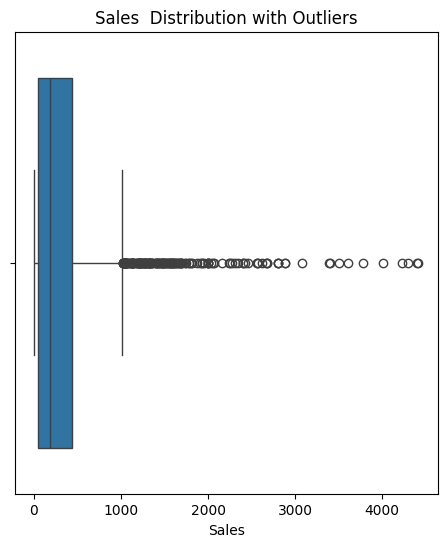

In [11]:
data_assessment.visualize_outliers(data_assessment.df,'Sales')

### Sales Distribution with Outliers Interpretation :
- This boxplot of sales distribution reveals that most transactions fall within a moderate range (likely $1000-$3000), with a concentration of smaller sales skewing the distribution to the right.

- The median sits closer to the lower end of the interquartile range, indicating that at least half of all sales are relatively modest in value.

- Beyond the upper whisker (approximately $4000), several high-value outliers appear, representing exceptionally large transactions that deviate significantly from typical order patterns.

- These outliers could stem from bulk purchases, premium product sales, or corporate orders, and warrant targeted analysis to determine whether they represent strategic opportunities or anomalies.

- The overall pattern suggests a customer base dominated by small to medium-sized purchases, with occasional high-impact sales that disproportionately contribute to total revenue.

- Businesses should investigate whether these outliers follow predictable patterns (like seasonal trends or specific customer segments) that could be intentionally replicated to drive revenue growth.

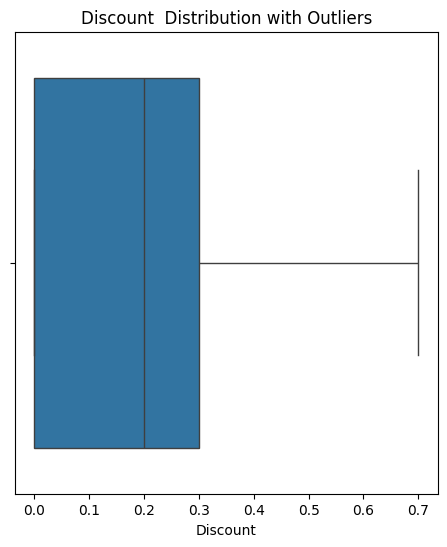

In [12]:
data_assessment.visualize_outliers(data_assessment.df,'Discount')

### Discount Distribution with Outliers Interpretation :
- This boxplot of discount distribution reveals that most products are sold with little to no discount (median likely near 0.0-0.1), as shown by the box's position close to zero.

- The interquartile range remains narrow, indicating consistent low discounting, with whiskers extending to approximately 0.4-0.5, beyond which lie outliers representing rare deep discounts (0.6-0.7).

- These extreme values could reflect clearance sales, promotional events, or pricing anomalies, suggesting minimal but strategic use of heavy discounts in the business model.

- The concentration near zero implies most sales occur at or near full price, which may indicate strong product value or limited price-based promotions.



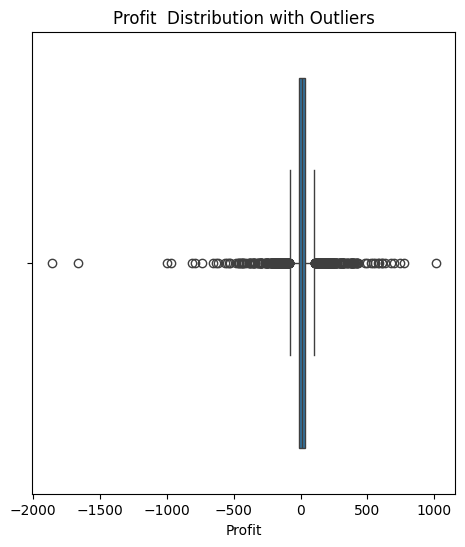

In [13]:
data_assessment.visualize_outliers(data_assessment.df,'Profit')

### Profit Distribution with Outliers Interpretation :

- This boxplot of profit distribution reveals a concerning pattern where the interquartile range spans from losses (-$500 to $0) to modest gains ($0 to $500), with the median hovering near the break-even point.

- The lower whisker extends to -$2000, indicating significant losses in some transactions, while the upper whisker reaches approximately $1000, showing limited profitable outliers.

- The concentration of data near zero profit and the substantial left tail suggest that many transactions are either unprofitable or barely breaking even, with only a few delivering meaningful profits.

- This could indicate pricing strategy issues, high operational costs, or problematic product lines. The presence of extreme losses (-$1500 to -$2000) warrants immediate investigation into specific customers, products, or discount practices causing these substantial negative margins.

- The business should prioritize identifying and addressing the root causes of these losses while analyzing the few high-profit outliers for replicable success factors.

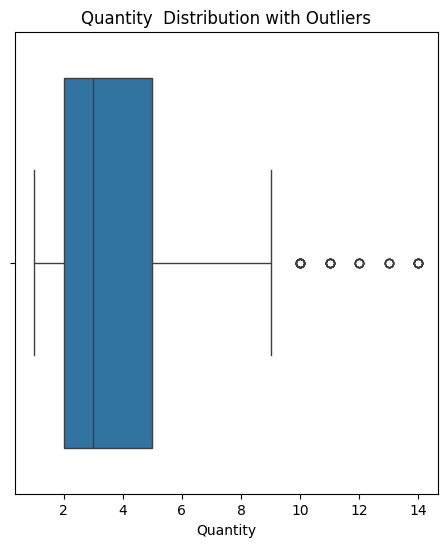

In [14]:
data_assessment.visualize_outliers(data_assessment.df,'Quantity')

### Quantity Distribution with Outliers Interpretation :

- This boxplot of quantity distribution shows that most orders contain relatively few items, with the interquartile range likely spanning 2-6 units and the median positioned near the lower end, indicating a right-skewed distribution where small orders dominate.

- The upper whisker extends to approximately 8-10 units, marking the threshold for typical order sizes, while outliers beyond this point (10-14+ units) represent unusually large orders that deviate significantly from normal purchasing behavior.

- These outliers could indicate bulk purchases, wholesale transactions, or stock-up events, suggesting opportunities to analyze customer segments or product categories that drive these larger orders.

- The overall pattern confirms the business primarily serves customers making small-quantity purchases, with occasional high-volume transactions that may disproportionately impact inventory or revenue.

### 📈 Missing values statistics

In [15]:
data_assessment.check_completeness()

-------------------------------
Missing values count per column:
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64
-------------------------------
Missing values percentage per column:
Row ID: 0.00%
Order ID: 0.00%
Order Date: 0.00%
Ship Date: 0.00%
Ship Mode: 0.00%
Customer ID: 0.00%
Customer Name: 0.00%
Segment: 0.00%
Country: 0.00%
City: 0.00%
State: 0.00%
Postal Code: 0.00%
Region: 0.00%
Product ID: 0.00%
Category: 0.00%
Sub-Category: 0.00%
Product Name: 0.00%
Sales: 0.00%
Quantity: 0.00%
Discount: 0.00%
Profit: 0.00%
-------------------------------


### 📈 Missing values visualization 🔍

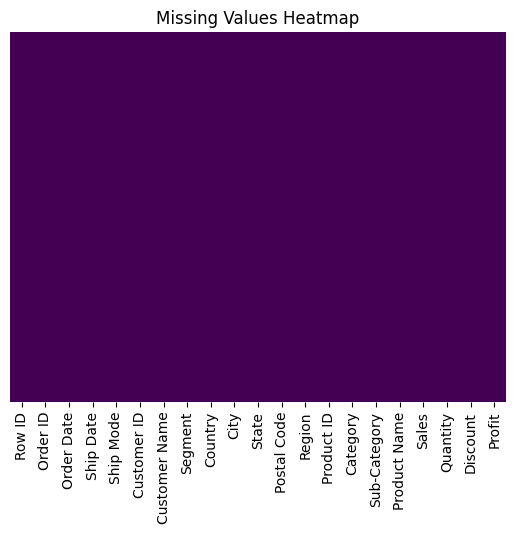

In [16]:
data_assessment.visualize_missing_values(data_assessment.df)

### Missing values HeatMap Interpretation :

The heatmap appears to show no missing values (null/NA values) across all variables in your dataset, as all fields are listed without any visual indication of missing data (which would typically be shown with color coding if missing values were present)

### 🔍 Variables distribution

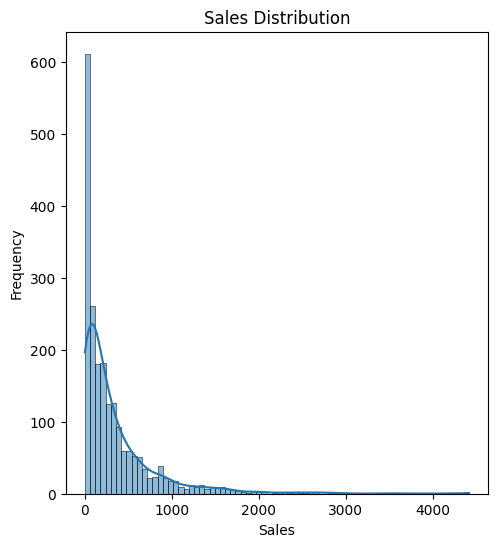

In [17]:
data_assessment.distribution_analysis(data_assessment.df,'Sales')

### Sales Distribution Interpretation :

- The sales distribution histogram shows a right-skewed pattern, indicating that most sales are concentrated at lower values, with fewer instances of higher sales amounts.

- The highest frequency (approximately 4000–5000 occurrences) corresponds to the smallest sales values, suggesting that the majority of transactions are modest in size.

- As sales amounts increase, their frequency drops sharply, with very few transactions reaching the highest sales brackets.

- This is typical in retail data, where many small purchases outweigh fewer large orders.

- Further analysis could explore whether these high-value sales represent bulk purchases, specific product categories, or seasonal spikes.


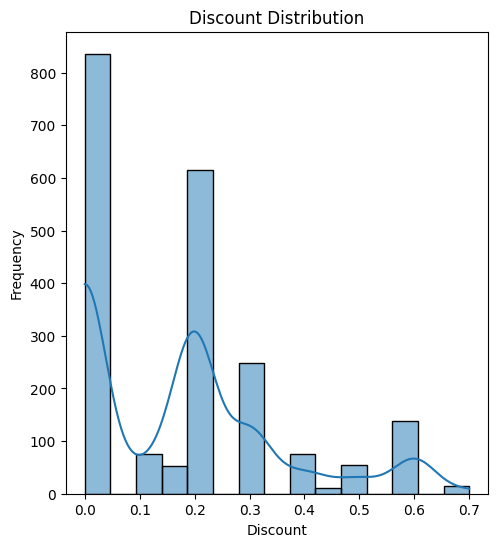

In [18]:
data_assessment.distribution_analysis(data_assessment.df,'Discount')

### Discount Distribution Interpretation :

- The discount distribution histogram reveals that most products are sold without discounts (peak at 0.0), with a sharp decline as discount rates increase.

- The frequency drops significantly beyond 0.2 (20% discount), indicating that higher discounts are relatively uncommon in this dataset.

- This pattern suggests the business primarily operates on minimal or no discounts, with occasional moderate discounts (10-20%) and rare deep discounts (30%+).

- Such a distribution could reflect a premium pricing strategy, seasonal promotions, or clearance events for specific products. Further segmentation by product category or customer segment could provide deeper insights into discounting strategies.

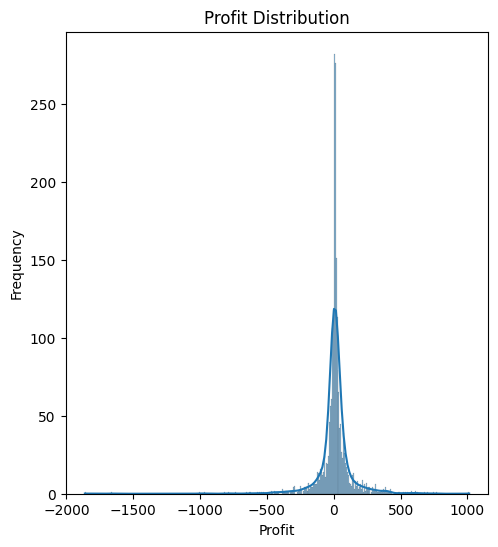

In [19]:
data_assessment.distribution_analysis(data_assessment.df,'Profit')

### Profit Distribution Interpretation :

- The profit distribution shows a concentrated peak around small positive values (near 0 to 500), indicating that most transactions generate modest profits. However, the presence of a left tail extending into negative values (losses) reveals that a subset of transactions is unprofitable, with some significant losses reaching -2000.

- This pattern suggests:

  1. Core profitability: The majority of sales yield low-to-moderate gains, typical of stable operations.

  2. Risk exposure: The left skew highlights problematic transactions—potentially from steep discounts, low-margin products, or operational inefficiencies.

  3. Outliers: Extreme losses (-2000) warrant investigation into specific products, customers, or promotions causing these outliers.

- Actionable insight: Prioritize analyzing loss-making segments ( high-discount sales or specific categories) to improve overall profitability. A breakdown by product or region could pinpoint root causes.

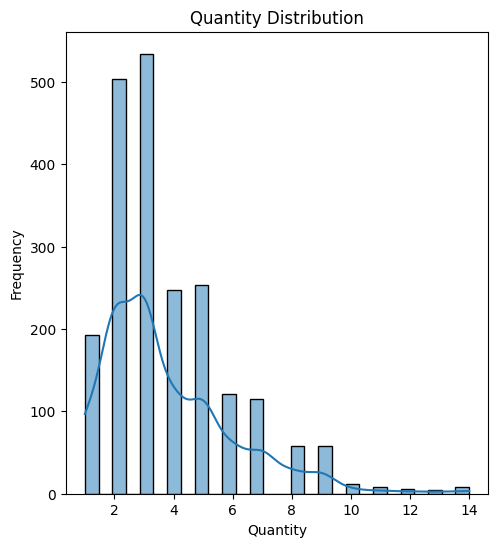

In [20]:
data_assessment.distribution_analysis(data_assessment.df,'Quantity')

### Profit Distribution Interpretation :

- The quantity distribution histogram reveals a right-skewed pattern, with the highest frequency (approximately 400 occurrences) at the lowest quantity (2 units). As order quantities increase, their frequency declines sharply—most transactions involve small quantities (2–6 units), while bulk orders (8+ units) are rare.

- Key Insights:

  1. Dominance of small orders: The business primarily serves customers making modest purchases, typical in B2C or retail environments.

  2. Limited bulk transactions: The sparse tail suggests minimal wholesale or high-volume activity, which may represent untapped opportunities.

  3. Potential action: Investigate whether low-quantity sales correlate with profitability (if small orders have higher margins) or explore incentives to boost larger purchases.

- Note: If quantities beyond 14 exist but aren’t shown, outliers might be trimmed—confirm the full data range for completeness.

In [22]:
# Now we need to work on another dataframe to keep our data safe
df=data_assessment.df

### Features Engineering

In [23]:
# Ensure 'Order Date' is datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Add new columns
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['DayOfWeek'] = df['Order Date'].dt.day_name()

# Ensure 'Order Date' is datetime
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Add new columns to checkout whether the Order Processing Time influences Sales and Profit
df['Order Processing Time'] = df['Order Date']- df['Ship Date']

### INSIGHTS FOR MANAGERS

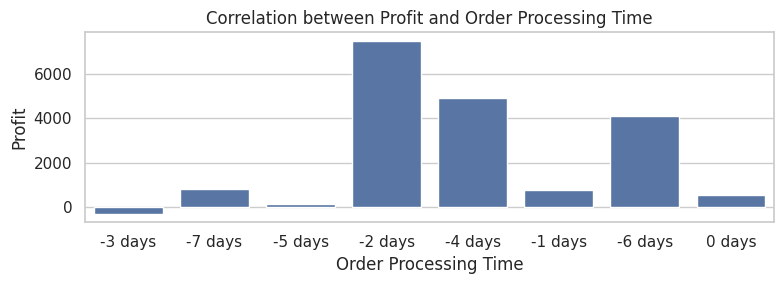

In [24]:
sns.set(style="whitegrid")

# 1️ Correlation between Profit and Order Processing Time
plt.figure(figsize=(8, 3))
sns.barplot(x='Order Processing Time', y='Profit', data=df, estimator=sum,errorbar=None)
plt.title("Correlation between Profit and Order Processing Time")
plt.ylabel("Profit")
plt.xlabel("Order Processing Time")
plt.tight_layout()
plt.show()

The order processing time does not seem to be significant

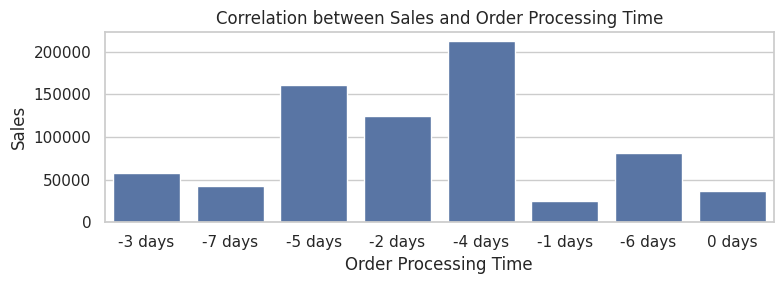

In [278]:
# STYLE GRAPHIQUE
sns.set(style="whitegrid")

# 2 Correlation between Sales and Order Processing Time
plt.figure(figsize=(8, 3))
sns.barplot(x='Order Processing Time', y='Sales', data=df, estimator=sum,errorbar=None)
plt.title("Correlation between Sales and Order Processing Time")
plt.ylabel("Sales")
plt.xlabel("Order Processing Time")
plt.tight_layout()
plt.show()

We conclude that the order processing time does not impact the sales and the profit. It means it is a weak feature

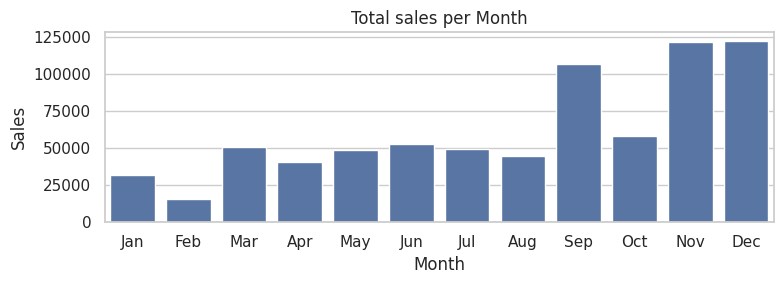

In [269]:
# STYLE GRAPHIQUE
sns.set(style="whitegrid")

# 3 Total sales per month
plt.figure(figsize=(8, 3))
sns.barplot(x='Month', y='Sales', data=df, estimator=sum,errorbar=None)
plt.title("Total sales per Month")
plt.ylabel("Sales")
plt.xlabel("Month")
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

We see clearly that sales increase during september november and december. Month could be an interesting feature that will help the model

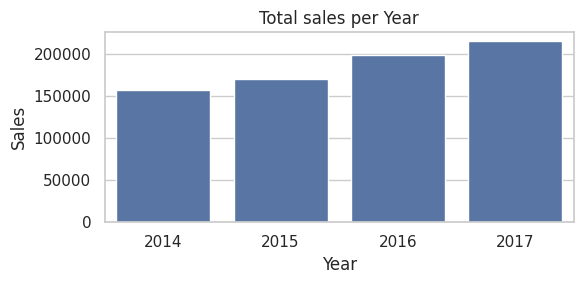

In [268]:
# STYLE GRAPHIQUE
sns.set(style="whitegrid")

# 4 Total sales per year
plt.figure(figsize=(6, 3))
sns.barplot(x='Year', y='Sales', data=df, estimator=sum,errorbar=None)
plt.title("Total sales per Year")
plt.ylabel("Sales")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

The year can't be a good feature as it is semantically weak

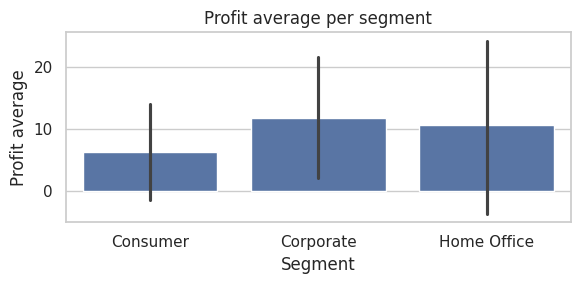

In [252]:
# 5 Profit average per segment
plt.figure(figsize=(6, 3))
sns.barplot(x='Segment', y='Profit', data=df)
plt.title("Profit average per segment")
plt.ylabel("Profit average")
plt.xlabel("Segment")
plt.tight_layout()
plt.show()

We see clearly that the segment type has impact on the profit average and i believe it is an interesting feature to consider for the model

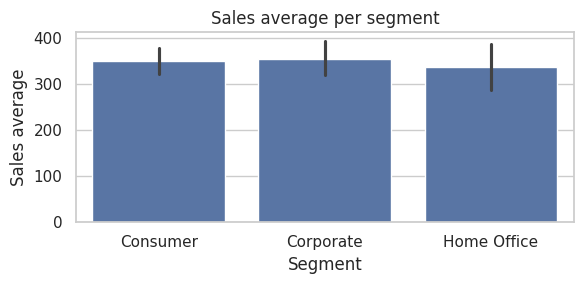

In [272]:
# 6 Profit average per segment
plt.figure(figsize=(6, 3))
sns.barplot(x='Segment', y='Sales', data=df)
plt.title("Sales average per segment")
plt.ylabel("Sales average")
plt.xlabel("Segment")
plt.tight_layout()
plt.show()

While the Segment was useful for the profit analysis, we see that there is not a real impact on sales

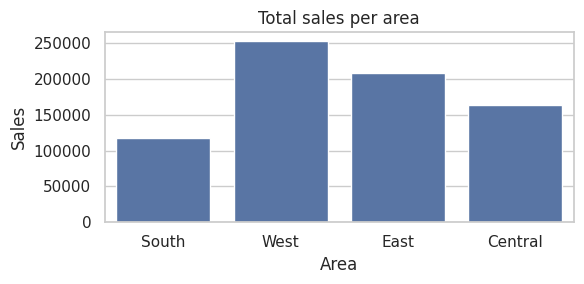

In [255]:
# 7 Total sales per region
plt.figure(figsize=(6, 3))
sns.barplot(x='Region', y='Sales', data=df, estimator=sum,errorbar=None)
plt.title("Total sales per region")
plt.ylabel("Sales")
plt.xlabel("Region")
plt.tight_layout()
plt.show()

The Region is a good feature because it shows the variation of the sales from a region to another

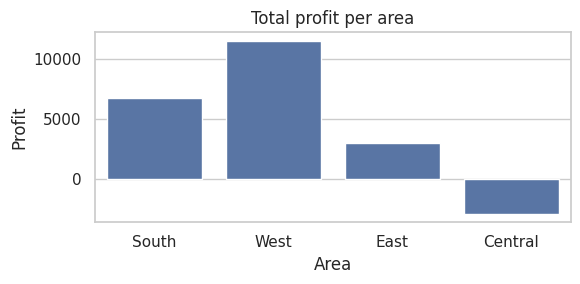

In [273]:
# 8 Total profit per region
plt.figure(figsize=(6, 3))
sns.barplot(x='Region', y='Profit', data=df, estimator=sum,errorbar=None)
plt.title("Total profit per region")
plt.ylabel("Profit")
plt.xlabel("Region")
plt.tight_layout()
plt.show()

Also, region is an interesting feature because it shows clearly the relationship between the profit and the region which is very informative for the model

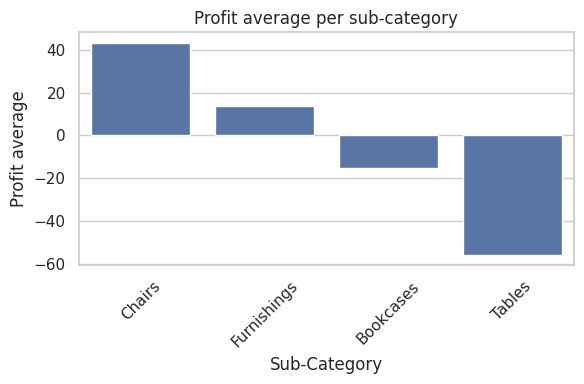

In [258]:
# 9 Profit average per sub-category
plt.figure(figsize=(6, 4))
subcat_profit = df.groupby('Sub-Category')['Profit'].mean().sort_values(ascending=False)
sns.barplot(x=subcat_profit.index, y=subcat_profit.values)
plt.title("Profit average per sub-category")
plt.ylabel("Profit average")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Sub category is also informative feature that can help the model during prediction

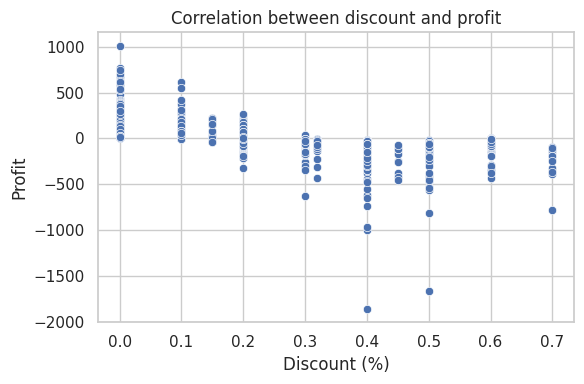

In [259]:
# 10 Correlation Between Discount and Profit
plt.figure(figsize=(6,4))
sns.scatterplot(x='Discount', y='Profit', data=df)
plt.title("Correlation between discount and profit")
plt.xlabel("Discount (%)")
plt.ylabel("Profit")
plt.tight_layout()
plt.show()


There is a clear relationship between the Discount and the profit so we consider the both as good features

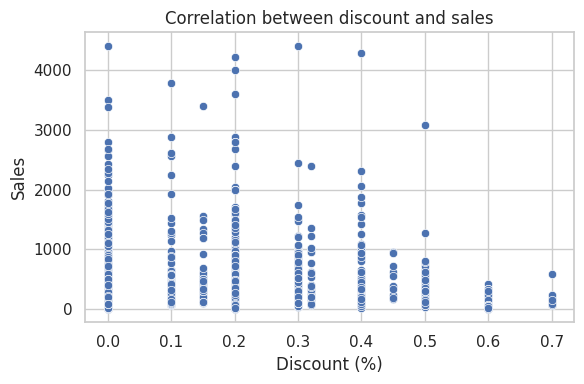

In [275]:
# 11 Correlation Between Discount and Sales
plt.figure(figsize=(6,4))
sns.scatterplot(x='Discount', y='Sales', data=df)
plt.title("Correlation between discount and sales")
plt.xlabel("Discount (%)")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

Also, there is a clear relationship between Sales and Discount so we consider them to be good features

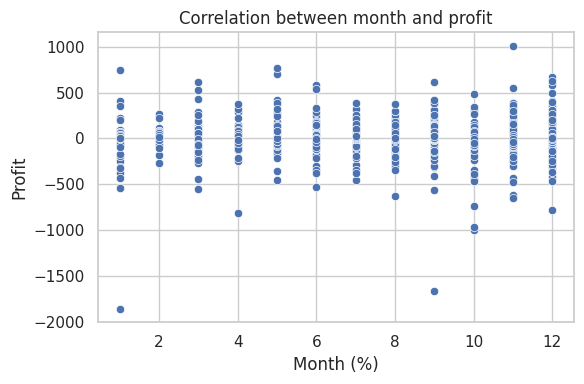

In [261]:
#  12 Correlation Between Month and Profit
plt.figure(figsize=(6,4))
sns.scatterplot(x='Month', y='Profit', data=df)
plt.title("Correlation between month and profit")
plt.xlabel("Month (%)")
plt.ylabel("Profit")
plt.tight_layout()
plt.show()

We can see a relationship between profit and month, even it's not too significative they still good features candidates to consider

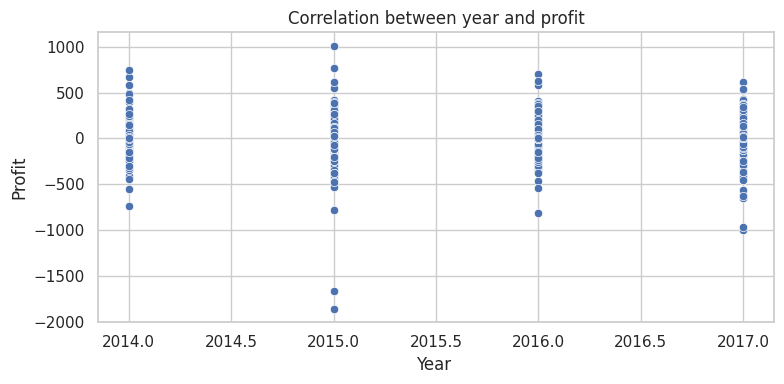

In [266]:
#  13 Correlation Between Year and Profit
plt.figure(figsize=(8,4))
sns.scatterplot(x='Year', y='Profit', data=df)
plt.title("Correlation between year and profit")
plt.xlabel("Year ")
plt.ylabel("Profit")
plt.tight_layout()
plt.show()

The year is not really significative in our case

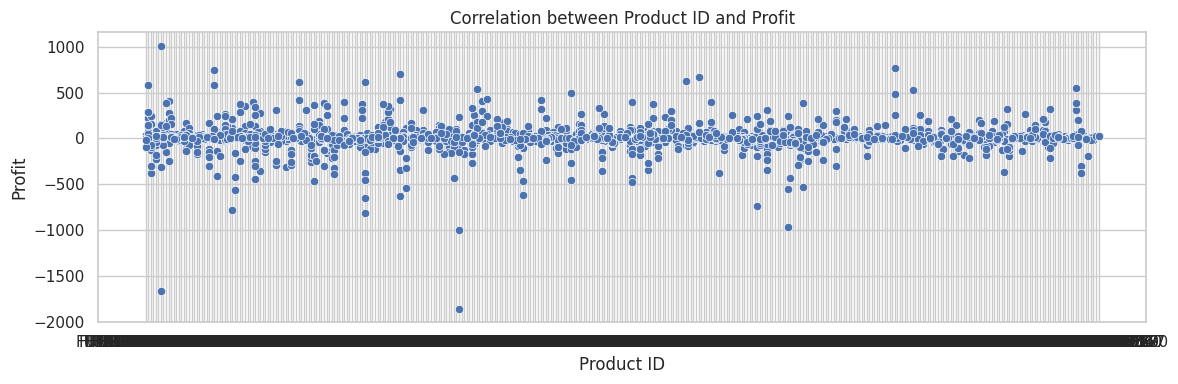

In [284]:
#  14 Correlation Between Product ID and Profit
plt.figure(figsize=(12,4))
sns.scatterplot(x='Product ID', y='Profit', data=df)
plt.title("Correlation between Product ID and Profit")
plt.xlabel("Product ID")
plt.ylabel("Profit")
plt.tight_layout()
plt.show()

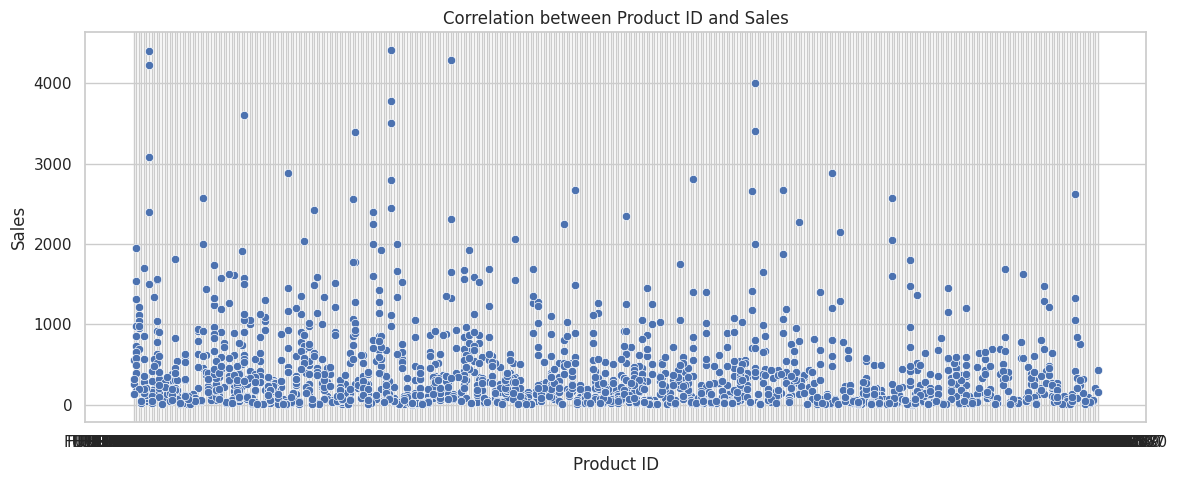

In [286]:
#  15 Correlation Between Product ID and Sales
plt.figure(figsize=(12,5))
sns.scatterplot(x='Product ID', y='Sales', data=df)
plt.title("Correlation between Product ID and Sales")
plt.xlabel("Product ID")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

For both sales and profit, we see clearly that the product is important  because there are relationships between the product id, sales and profit

### Features Candidates :

 1. Sales, Profit, Discount, Month, Sub category, Product ID, Segment, Region
 2. Sales, Profit, Discount, Month

In [52]:
# Evaluation of the first candidates using RandomForestRegressor
features = ['Profit', 'Discount','Sub-Category','Month', 'Product ID','Segment', 'Region']
X = df[features]
y = df['Sales']
categorical_cols = ['Sub-Category','Product ID','Segment', 'Region']

In [53]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', TargetEncoder(target_type='continuous'), categorical_cols)
    ],
    force_int_remainder_cols=False
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# Use the defined pipeline model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('cat',
                                                  TargetEncoder(target_type='continuous'),
                                                  ['Sub-Category', 'Product ID',
                                                   'Segment', 'Region'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [55]:
# Prediction
preds = model.predict(X_test)

# Quality of the regression
mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 221.14
RMSE: 201322.44
R2: 0.34


In [63]:
# Evaluation of the second candidates using RandomForestRegressor
features = ['Profit', 'Discount','Month']
X = df[features]
y = df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
model = Pipeline(steps=[
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])


In [45]:
# Use the defined pipeline model
model.fit(X_train, y_train)

Pipeline(steps=[('regressor', RandomForestRegressor(random_state=42))])

In [46]:
# Prediction
preds = model.predict(X_test)

# Quality of the regression
mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 139.06
RMSE: 96345.19
R2: 0.69


The second candidates seem to be better than the first candidates all metrics reduced

In [47]:
import xgboost as xgb
from xgboost import XGBRegressor

In [50]:
# Train XGBoost Regressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [51]:
# Prediction
preds = model.predict(X_test)

# Quality of the regression
mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 154.79
RMSE: 128071.83
R2: 0.58


In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "SVR": SVR()
}

# Train and store predictions
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = preds

In [65]:
# Define evaluation metrics
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R²": r2}

# Compare all models
comparison = {}
for name, preds in results.items():
    comparison[name] = evaluate(y_test, preds)

# Convert to DataFrame for better visualization
comparison_df = pd.DataFrame(comparison).T
print(comparison_df.sort_values(by="R²", ascending=False))

                          MAE        RMSE        R²
Gradient Boosting  133.898765  298.650575  0.708922
Random Forest      139.056131  310.395214  0.685578
XGBoost            168.049010  378.377662  0.532767
SVR                247.162545  525.740037  0.097962
Linear Regression  331.463332  539.641920  0.049627


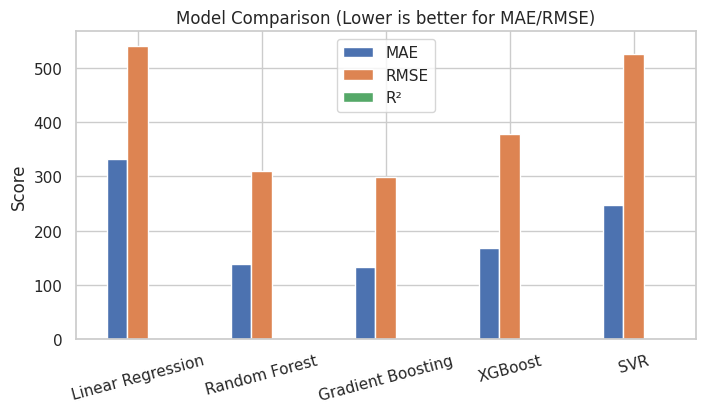

In [67]:
import matplotlib.pyplot as plt

comparison_df.plot(kind="bar", figsize=(8, 4))
plt.title("Model Comparison (Lower is better for MAE/RMSE)")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.show()

### Features Importance Explainability :

We will chose three best models

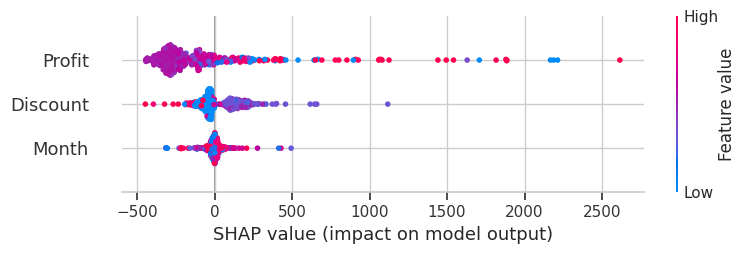

In [68]:
import shap

# Explain XGBoost
best_model = models["XGBoost"]
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

# Plot feature importance
shap.summary_plot(shap_values, X_test)

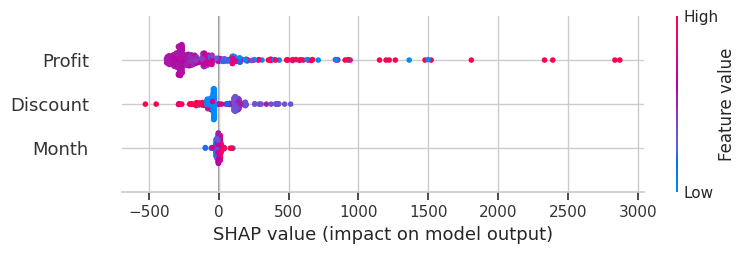

In [69]:
import shap

# Explain Gradient Boosting
best_model = models["Gradient Boosting"]
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

# Plot feature importance
shap.summary_plot(shap_values, X_test)

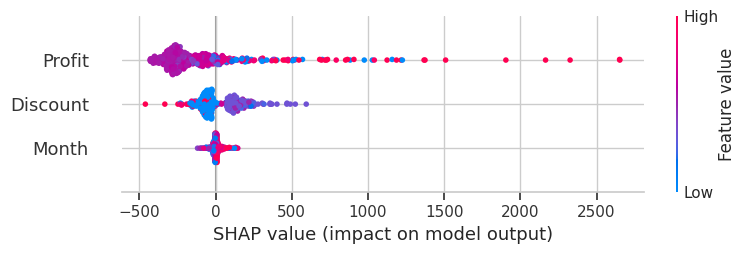

In [70]:
import shap

# Explain Random Forest
best_model = models["Random Forest"]
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

# Plot feature importance
shap.summary_plot(shap_values, X_test)